# One-Dimensional linear Aquifer Storage with MODFLOW6 and Flopy

In this notebook, we will learn how to:
1. Setup a MODFLOW6 model for one-dimensional flow and transport in a single layer.
2. Simulate injection of freshwater.
3. Visualize the output and check the mass balance.

Before you can start, you have to make sure you have installed the flopy package (`pip install flopy`) and that you have downloaded the MODFLOW6 executable from [here](https://github.com/MODFLOW-USGS/executables) (this will download a zip file with many executables from the MODFLOW family; for this class you only need to keep the `mf6` executable). Put the `mf6` executable in a subdirectory `bin` one directory down from the directory that contains this notebook.

In [16]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.optimize import fmin
plt.rcParams['figure.figsize'] = (5, 3) # set default figure size
import flopy as fp  # import flopy and call it fp

## Description of the flow problem
Consider one-dimensional flow in a semi-infinite confined aquifer. The aquifer extends from $x=0$ to $x=L$ in the $x$ direction, where $L$ is chosen far enough away not to effect the flow solution.  Water is injected at the left side at a rate $U$ such that the average velocity in the aquifer is 1 m/d. The head is fixed on the right side to $h_R$. Flow is considered to be at steady state instantaneously. 

The initial salt concentration is equal to $c_s$ everywhere. Injection of fresh water with concentration $c_f$ starts at $t=0$. 

In [17]:
# domain size and boundary conditions
L = 80 # length of domain, m
hR = 0 # head at right side of domain

# aquifer parameters
k = 20 # hydraulic conductivity, m/d
H = 20 # aquifer thickness, m
npor = 0.25 # porosity, -

# flow
vavg = 1 # average velocity, m/d
U = vavg * npor * H # computed total inflow, m^2/d

# transport
alphaL = 0.1 # longitudinal dispersivity in horizontal direction, m
alphaT = alphaL / 10 # transverse dispersivity is 10 times smaller than longitudinal, m
diffusion_coef = 0 # diffusion is not modeled

# concentration
cs = 35 # initial concentration, kg/m^3 (=g/L)
cf = 0 # concentration injected water, kg/m^3 (=g/L)

# space discretization
delr = 0.2 # length of cell along row (in x-direction), m
delc = 1 # width of cells normal to plane of flow (in y-direction), m
z = [0, -H] # top and bottom(s) of layers
nlay = 1 # number of layers
nrow = 1 # number of rows
ncol = round(L / delr) # number of columns
xg = np.cumsum(delr * np.ones(ncol)) - delr / 2 # centers of grid cells, m

# time and time discretization
tin = 40 # injection time, d
delt = 0.1 # time step, d
nstep = round(tin / delt) # computed number of steps, integer

# model name and workspace
modelname = 'model1d' # name of model
gwfname = modelname + 'f' # name of flow model
gwtname = modelname + 't' # name of transport model
modelws = './' + modelname # model workspace to be used (where MODFLOW will store all the files)

In MODFLOW6 the first step is to create a so-called `Simulation`. A simulation may contain one or more models. Here, the simulation contains a groundwater flow model and a groundwater transport model. These models may use different solvers, but share the same time discretization.

The general process of generating a combined groundwater flow and tranport simulation in MODFLOW6 is:
* Define the model name and workspace
* Create simulation and call it `sim`
  * Add time discretization to `sim`
  * Add groundwater flow model (called `gwf`) to `sim`
    * Add iterative model solver to `gwf` and register solver
    * Add features to groundwater model `gwf` (multiple steps)
  * Add transport model (called `gwt`) to `sim`
    * Add iterative model solver to `gwt` and register solver
    * Add features to groundwater model `gwt` (multiple steps)
* Write MODFLOW input files for `sim`
* Solve simulation `sim`
* Read MODFLOW output for `sim`
* Visualize output

## Create Simulation
Create a simulation and store it in the variable `sim`. The meaning of the keywords is explained in the comments at the end of each line (unless it is self-explanatory).

The time discretization is defined as part of the simulation. The time units are defined as days, but this is used only to control the text in the output files. The user is responsible for making sure that the length and time units of all model variables are consistent. Here, we use meters and days.

Each simulation is divided into stress periods. 
All stresses are constant during a stress period. 
For each stress period,  the length of the period, the number of steps during the period, and a timestep multiplier must be specified.
The `perioddata` is a list with a list of `[period length, number of steps, timestep multiplier]` for each stress period.  

In [18]:
# simulation
sim = fp.mf6.MFSimulation(sim_name=modelname, # name of simulation
                          version='mf6', # version of MODFLOW
                          exe_name='../bin/mf6', # path to MODFLOW executable
                          sim_ws=modelws, # path to workspace where all files are stored
                         )

# time discretization
tdis = fp.mf6.ModflowTdis(simulation=sim, # add to the simulation called sim (defined above)
                          time_units="DAYS", 
                          nper=1, # number of stress periods 
                          perioddata=[[tin, nstep, 1]], # period length, number of steps, timestep multiplier
                         )

## Create groundwater flow model (`gwf`)
A groundwater flow model is added to the simulation. The groundwater flow model is stored in the variable `gwf`.
The following features are added to the groundwater flow model `gwf`:
* Iterative model solver \
  The iterative model solver is defined and added to the simulation (not the groundwater model) and must include a separate file name. After creation, the iterative model solver needs to be registered with the simulation (this is a somewhat strange step that can hopefully be done automatically by flopy in the future). 
* Spatial discretization \
  All function arguments are self explanatory and previously defined. 
* Aquifer properties \
  Specify the hydraulic conductivity of the layer (which may be different for each layer in case there are multiple layers).
* Initial conditions \
  Initial conditions must be specified for all simulations, even for steady simulations (where they serve as starting guesses for the iterative solution).
* Inflow on the left side of the model \
  Inflow is simulated by specifying a well in the first cell (column 0) by specifying the location and discharge (positive for injecting water, negative for extracting water) and the concentration of the injected water (the concentration is an auxiliary variable and it must be specified separately that the auxiliary variable is indeed concentration). Wells are constant for a stress period bu may change from one stress period to another. The `stress_period_data` is a dictionary with all the wells for each stress period (we only have 1 well), starting with period 0. A nested list is provided for each stress period with a list for each well containing a tuple with (layer, row, column) of the cell where the well is located, the discharge, and the concentration of the injected water. 
```
{stress_period number: [[(layer, row, column), discharge, conc]],
 stress_period number: [[(layer, row, column), discharge, conc]], ... }
```
* Specified head on the right side of the model \
  Specified head cells are specified in a similar manner as wells by specifying the stress period data, but now the discharge is replaced by the specified_head.
* Output control \
  The output control package determines which output is saved and how frequent. The `saverecord` keyword has many options to save only part of the model output (useful for large models), for example heads or water budget terms. For this small model, we save `ALL` values.

In [19]:
# groundwater flow model
gwf = fp.mf6.ModflowGwf(simulation=sim, # add to simulation called sim
                        modelname=gwfname, # name of gwf model
                        save_flows=True, # make sure all flows are stored in binary output file
                       )

# iterative model solver
gwf_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation called sim
                             filename=gwf.name + '.ims', # file name to store ims
                             linear_acceleration="BICGSTAB", # use BIConjuGantGradientSTABalized method
                            )                                                                                                
# register solver
sim.register_ims_package(solution_file=gwf_ims, # name of iterative model solver instance
                         model_list=[gwf.name], # list with name of groundwater flow model
                        )   

# discretization
gwf_dis = fp.mf6.ModflowGwfdis(model=gwf, # add to groundwater flow model called gwf
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# aquifer properties
gwf_npf  = fp.mf6.ModflowGwfnpf(model=gwf, 
                                k=k, # horizontal k value
                                save_flows=True, # save the flow for all cells
                               )
    
# initial condition
gwf_ic = fp.mf6.ModflowGwfic(model=gwf, 
                             strt=hR, # initial head used for iterative solution
                            )

# wells
wellin = [[(0, 0, 0),  U, cf]]   # [(layer, row, col), U, concentration]
wel_spd = {0: wellin} # stress period data for period 0 is wellin
gwf_wel = fp.mf6.ModflowGwfwel(model=gwf, 
                               stress_period_data=wel_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='WEL1', # package name
                              )

# constant head 
chd0 = [[(0,  0,  ncol-1), hR, cs]] # [(layer, row, col), head, concentration]
chd_spd  = {0: chd0} # stress period data
gwf_chd = fp.mf6.ModflowGwfchd(model=gwf, 
                               stress_period_data=chd_spd, 
                               auxiliary=['CONCENTRATION'],
                               pname='CHD1', # package name
                              )
    
# output control
oc = fp.mf6.ModflowGwfoc(model=gwf, 
                         saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwfname}.cbc", # file name where all budget output is stored
                         head_filerecord=f"{gwfname}.hds", # file name where all head output is stored
                        )

## Create groundwater transport model (`gwt`)
A transport model is added to the simulation. The transport model is stored in the variable `gwt`.
The following features are added to the groundwater transport model `gwt`:
* Iterative model solver \
  A separate iterative solver instance must be defined and added to the simuluation `sim`, even when all solver settings are the same as for the groundwater flow model. The iterative model solver must include a file name that is different from the file name used for the groundwater flow model. As for the `gwf` model, the iterative model solver must be registered with the simulation.
* Spatial discretization \
  All function arguments are the same as for the groundwater flow model. It may seem silly to have to define the discretization again, but it is actually possible to do a transport model without a groundwater flow model (but we are not doing that). 
* Storage and transfer \
  Specify the porosity of the layer (which may be different for each layer in case there are multiple layers).
* Initial conditions \
  Specify the initial concentration. Here it is constant, so 1 value is sufficient, but this may also be an array with a different value for each cell (as we will do when when we will start simulating multiple cycles). 
* Source sink mixing \
  Specify how concentration is assigned for sources and sinks in the flow model. We have both wells and constant head cells for which we specified the concentration through a `'CONCENTRATION'` auxiliary variable. Use the `pname` that are specified for the WEL and CHD packages.
* Advection \
  Specify what solution method to use for the advection term.
* Dispersion \
  Specify the dispersivity and the diffusion coefficient.
* Output control \
  Similar to the output control of the groundwater flow model, but now save the concentration rather than the head.

In [20]:
# groundwater transport model
gwt = fp.mf6.ModflowGwt(simulation=sim, 
                        modelname=gwtname, # name of groundwater transport model
                       )

# iterative model solver
gwt_ims  = fp.mf6.ModflowIms(simulation=sim, # add to simulation
                             filename=gwt.name + '.ims', # must be different than file name of gwf model ims
                             linear_acceleration="BICGSTAB",
                            ) 
sim.register_ims_package(solution_file=gwt_ims, 
                         model_list=[gwt.name],
                        )

# discretization
gwt_dis = fp.mf6.ModflowGwtdis(model=gwt, # add to gwt model
                               nlay=nlay, 
                               nrow=nrow, 
                               ncol=ncol, 
                               delr=delr, 
                               delc=delc, 
                               top=z[0], 
                               botm=z[1:], 
                              )

# mobile storage and transfer
gwt_sto = fp.mf6.ModflowGwtmst(model=gwt, 
                               porosity=npor, # porosity
                               save_flows=True,
                              )

# initial condition
gwt_ic = fp.mf6.ModflowGwtic(model=gwt, 
                             strt=cs, # initial concentration
                            ) 

# source sink mixing
sourcelist = [("WEL1", "AUX", "CONCENTRATION"), ("CHD1", "AUX", "CONCENTRATION")] # list of (pname, 'AUX', 'CONCENTRATION')
ssm = fp.mf6.ModflowGwtssm(model=gwt, 
                           sources=sourcelist, 
                           save_flows=True,
                           pname='SSM1', 
                          )

# advection
adv = fp.mf6.ModflowGwtadv(model=gwt,  
                           scheme="TVD", # use the Total Variation Diminishing (TVD) method
                           pname='ADV1',
                          )

# dispersion
dsp = fp.mf6.ModflowGwtdsp(model=gwt, 
                           alh=alphaL, # longitudinal dispersivity
                           ath1=alphaT, # transverse dispersivity
                           diffc=diffusion_coef, # diffusion coefficient
                           pname='DSP1', 
                          )

# output control
oc = fp.mf6.ModflowGwtoc(model=gwt,
                         saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")], # what to save
                         budget_filerecord=f"{gwtname}.cbc", # file name where all budget output is stored
                         concentration_filerecord=f"{gwtname}.ucn", # file name where all concentration output is stored
                        )

Define the interaction between the groundwater flow model and the transport model and add it to the simulation.

In [21]:
fp.mf6.ModflowGwfgwt(simulation=sim, 
                     exgtype="GWF6-GWT6", 
                     exgmnamea=gwf.name, # name of groundwater flow model 
                     exgmnameb=gwt.name, # name of transport model
                     filename=f"{modelname}.gwfgwt",
                    );

## Write input files and solve model
We are finally ready to write the input files and solve the model. First, we write the input files. This will print a lot of information to the screen (which can be silenced if desired with the `silent=True` option).
Note that `flopy` creates a subdirectory called `model1` (the `modelws` defined in one of the first code cells of this notebook) that contains all the MODFLOW input files. Check the `modelws` directory to see what files were created. You may also inspect the contents of some of the files. Their exact format is specified in the USGS manual mfio.pdf. FloPy takes care of all the painstaking work that is required to create these input files by hand!

Finally, we solve the model. If all goes well, the final statement on the screen is `Normal termination of simulation.`

In [22]:
sim.write_simulation(silent=True)
success, _ = sim.run_simulation(silent=True) 
if success == 1:
    print('Model solved successfully')
else:
    print('Solve failed')

Model solved successfully


## Read head data and make plot

In [23]:
hds = gwf.output.head() # get handle to binary head file
head = hds.get_alldata().squeeze() # get the head data from the file, array of (ntime_steps, ncol)
print(f'min, max head in model: {head[0].min():.2f}, {head[0].max():.2f} m')

min, max head in model: 0.00, 1.00 m


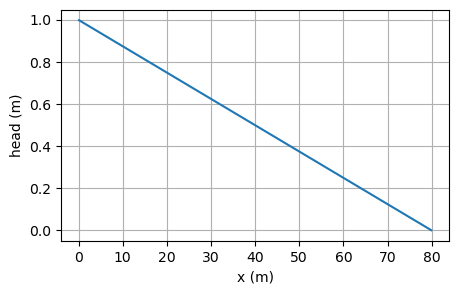

In [24]:
plt.plot(xg, head[0]) # plot head for first time step (head is same for all time steps)
plt.xlabel('x (m)')
plt.ylabel('head (m)')
plt.grid()

## Read concentration data and make plot
In absence of dispersion, the concentration line jumps abruptly from 35 g/L to 0 at the front of the injecgtions, which is shown with the dashed colored lines (recall that the average velocity of the groundwater is 1 m/d for this case). The horizontal black dashed line is half the concentration of seawater.

In [25]:
cobj = gwt.output.concentration() # get handle to binary concentration file
c = cobj.get_alldata().squeeze() # get the concentration data from the file

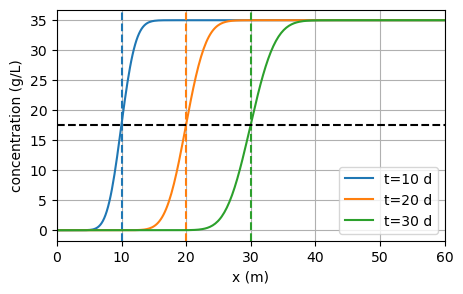

In [26]:
# plot concentration vs. x for three different times
times = np.array(cobj.get_times())    
for i, t in enumerate([10, 20, 30]):
    itime = np.abs(times - t).argmin() # find index of value in times closest to t
    plt.plot(xg, c[itime,:], 'C' + str(i), label=f't={times[itime]:.0f} d')
    plt.axvline(t, color='C' + str(i), ls='--') # vertical dashed line at front of injection
plt.axhline(cs / 2, color='k', ls='--') # horizontal black dashed line at c=cs/2
plt.xlabel('x (m)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 60)
plt.legend()
plt.grid()

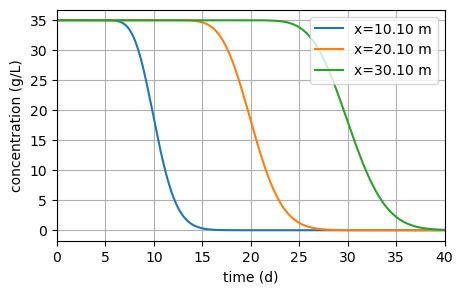

In [27]:
# plot concentration vs. time at three different locations
for x in [10, 20, 30]:
    ix = np.abs(xg - x).argmin() # find index of value in xg closest to x
    plt.plot(times, c[:, ix], label=f'x={xg[ix]:.2f} m')
plt.xlabel('time (d)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 40)
plt.legend(loc='upper right')
plt.grid()

## Mass balance
During a time step, freshwater with concentration $c_f$ flows into the system at a rate $U$, while saltwater with concentration $c_s$ flows out of the system at a rate $U$ (recall that flow is stationary). Hence, the change in mass of salt $\Delta M_1$ (positive for an increase in mass) in the system during a time step is \begin{equation}
\Delta M_1 = (U c_f - U c_s)\Delta t
\end{equation}
If the mass balance is met, this change in mass must be equal to the change in mass in the system $\Delta M_2$
\begin{equation}
\Delta M_2 = \sum_i{(c_i(t)-c_i(t-\Delta t) H n\Delta x}
\end{equation}
where $\Delta x$ is the cell size in $x$-direction (i.e., `delr`). The mass balance is computed for one time step as follows 

In [85]:
itime = 10 # time step for which mass balance is checked
delM1 = (U * cf - U * cs) * delt
delM2 = np.sum(c[itime] - c[itime - 1]) * H * npor * delr
print(f'mass balance from inflow and outflow: {delM1} kg')
print(f'mass balance from storage change: {delM2} kg')

mass balance from inflow and outflow: -17.5 kg
mass balance from storage change: -17.50000000000008 kg


## Homework
### Problem 1
The exact solution for the stated problem is (Van Genuchten and Alves, 1982):
\begin{equation}
c(x, t) = c_s + (c_f-c_s)\left[\frac{1}{2}\text{erfc}\left(\frac{x-vt}{2\sqrt{DT}}\right) + 
\sqrt{\frac{v^2t}{\pi D}} \exp\left(\frac{-(x-vt)^2}{4Dt}\right) -
\frac{1}{2}\left(1 + \frac{vx}{D} + \frac{v^2t}{D}\right)\exp\left(\frac{vx}{D}\right)
\text{erfc}\left(\frac{x+vt}{2\sqrt{DT}}\right)\right]
\end{equation}
where $D=\alpha_Lv$ is the dispersion coefficient, $v$ is the average velocity, and erfc is the complimentary error function (available as `erfc` in `scipy.special`). 
Plot the concentration vs. $x$ using the exact soljution for $t=10$, $20$, and $30$ d. Plot the concentration simulated with MODFLOW and the exact concentration in the same graph. Add a legend. Note the effect of numerical disperion.
### Problem 2
For the given problem and parameters, deterimine the dispersion coefficient that should be used in the exact solution such that you get the best fit between the exact solution and the MODFLOW solution in a least squares sense for $t=10$, $20$, and $30$ d (so three separate dispersion coeffcients). Hint: use the `fmin` function of `scipy.optimize`. Make the same plot as for Problem 2, but now with the optimized value of the dispersion coefficient. Note that this optimized dispersion coefficient includes the effect of numerical dispersion. Report the value of the optimized dispersion coefficient for this problem (three values for the three times that were analyzed). 

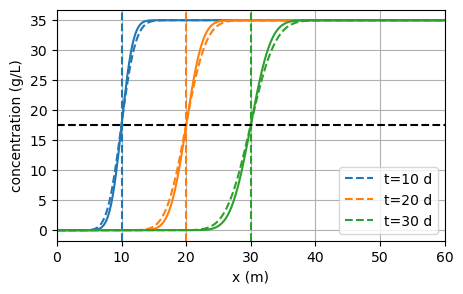

In [41]:

times = np.array(cobj.get_times())  

def c_exact(x,t, alphaL):
    v = vavg
    D = alphaL * vavg
    a_1 = 0.5 * erfc((x - v * t)/(2 * np.sqrt(D * t)))
    a_2 = np.sqrt(v**2 * t/ (np.pi * D)) * np.exp(- (x - v * t)**2/(4 * D * t))
    a_3 = - 0.5 * (1 + (v * x) / D + (v**2 * t) / D) * np.exp(v * x / D) * erfc((x + v * t)/(2 * np.sqrt(D * t)))
    c = cs + (cf-cs)*(a_1 + a_2 + a_3 )
    return c

for i, t in enumerate([10, 20, 30]):
    itime = np.abs(times - t).argmin() # find index of value in times closest to t
    plt.plot(xg, c_exact(xg, t, alphaL))
    plt.plot(xg, c[itime,:], 'C' + str(i), ls='--', label=f't={times[itime]:.0f} d')
    plt.axvline(t, color='C' + str(i), ls='--') # vertical dashed line at front of injection

plt.axhline(cs / 2, color='k', ls='--') # horizontal black dashed line at c=cs/2
plt.xlabel('x (m)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 60)
plt.legend()
plt.grid()


Optimization terminated successfully.
         Current function value: 0.747109
         Iterations: 8
         Function evaluations: 16
Optimum value is 0.153 m for t = 10 d
Optimization terminated successfully.
         Current function value: 0.557168
         Iterations: 8
         Function evaluations: 16
Optimum value is 0.152 m for t = 20 d
Optimization terminated successfully.
         Current function value: 0.463731
         Iterations: 8
         Function evaluations: 16
Optimum value is 0.151 m for t = 30 d


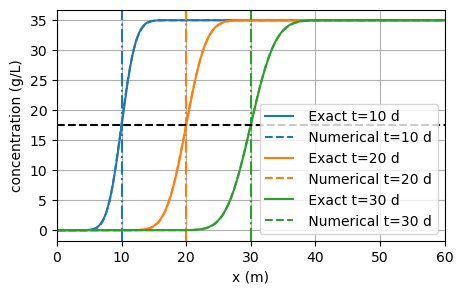

In [80]:
def c_exact1(x,t, D):
    v=vavg
    a_1 = 0.5 * erfc((x - v * t)/(2 * np.sqrt(D * t)))
    a_2 = np.sqrt(v**2 * t/ (np.pi * D)) * np.exp(- (x - v * t)**2/(4 * D * t))
    a_3 = - 0.5 * (1 + (v * x) / D + (v**2 * t) / D) * np.exp(v * x / D) * erfc((x + v * t)/(2 * np.sqrt(D * t)))
    c = cs + (cf-cs)*(a_1 + a_2 + a_3 )
    return c

def min_f(D,x,t):
    itime = np.abs(times - t).argmin()
    c_exact = c_exact1(xg,t,D)
    c_model = c[itime,:]
    diff_err = (c_model - c_exact)**2
    diff_used = diff_err[~np.isnan(diff_err)]
    lsq = np.sum(diff_used)
    return lsq

for i, t in enumerate([10, 20, 30]): 
    itime = np.abs(times - t).argmin() # find index of value in times closest to t
    opt_value = fmin(min_f,0.15,args=(xg,t))
    plt.plot(xg, c_exact1(xg,t,opt_value), 'C' + str(i), ls='-', label=f' Exact t={times[itime]:.0f} d')
    plt.plot(xg, c[itime,:], 'C' + str(i), ls='--', label=f' Numerical t={times[itime]:.0f} d')
    plt.axvline(t, color='C' + str(i), ls='-.') # vertical dashed line at front of injection
    print(f'Optimum value is {opt_value[0]:.3f} m for t = {times[itime]:.0f} d')
          
plt.axhline(cs / 2, color='k', ls='--') # horizontal black dashed line at c=cs/2
plt.xlabel('x (m)')
plt.ylabel('concentration (g/L)')
plt.xlim(0, 60)
plt.legend()
plt.grid()

